In [36]:
import pandas as pd
import sys
sys.path.append("..")
from utility import utility_functions as utf
from utility.db_util import db_reader
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split
from tensorflow import keras
from keras import layers
from keras_tuner import Hyperband
from tensorflow import saved_model 

In [21]:
df1 = get_data('between_11min_and_13min_ride_df')
df2 = get_data('between_14min_and_25_min_ride_df')
df3 = get_data('under_11min_ride_df')

In [22]:
df1_best_model , df1_X_train_scaled , df1_y_train = get_best_network(df1,'df1')
df2_best_model , df2_X_train_scaled , df2_y_train = get_best_network(df2,'df2')
df3_best_model , df3_X_train_scaled , df3_y_train = get_best_network(df3,'df3')


INFO:tensorflow:Reloading Oracle from existing project keras_tuner_mse\df1\oracle.json
INFO:tensorflow:Reloading Tuner from keras_tuner_mse\df1\tuner0.json
INFO:tensorflow:Oracle triggered exit
units1 128
units2 256
units3 96
INFO:tensorflow:Reloading Oracle from existing project keras_tuner_mse\df2\oracle.json
INFO:tensorflow:Reloading Tuner from keras_tuner_mse\df2\tuner0.json
INFO:tensorflow:Oracle triggered exit
units1 288
units2 160
units3 448
INFO:tensorflow:Reloading Oracle from existing project keras_tuner_mse\df3\oracle.json
INFO:tensorflow:Reloading Tuner from keras_tuner_mse\df3\tuner0.json
INFO:tensorflow:Oracle triggered exit
units1 224
units2 288
units3 160


In [23]:
df1_hist = train_model(df1_best_model,df1_X_train_scaled,df1_y_train)
df2_hist = train_model(df2_best_model,df2_X_train_scaled,df2_y_train)
df3_hist = train_model(df3_best_model,df3_X_train_scaled,df3_y_train)

Epoch 1/100
505/505 [==============================] - 3s 5ms/step - loss: 10678.1553 - mse: 10678.1553 - val_loss: 10879.4453 - val_mse: 10879.4453
Epoch 2/100
505/505 [==============================] - 2s 4ms/step - loss: 10118.6084 - mse: 10118.6084 - val_loss: 10578.4932 - val_mse: 10578.4932
Epoch 3/100
505/505 [==============================] - 2s 4ms/step - loss: 9832.8877 - mse: 9832.8877 - val_loss: 10185.6895 - val_mse: 10185.6895
Epoch 4/100
505/505 [==============================] - 2s 4ms/step - loss: 9639.1250 - mse: 9639.1250 - val_loss: 9991.6592 - val_mse: 9991.6592
Epoch 5/100
505/505 [==============================] - 2s 4ms/step - loss: 9423.3760 - mse: 9423.3760 - val_loss: 10097.0303 - val_mse: 10097.0303
Epoch 6/100
505/505 [==============================] - 2s 4ms/step - loss: 9170.7412 - mse: 9170.7412 - val_loss: 9618.8574 - val_mse: 9618.8574
Epoch 7/100
505/505 [==============================] - 2s 4ms/step - loss: 8973.0117 - mse: 8973.0117 - val_loss: 9341

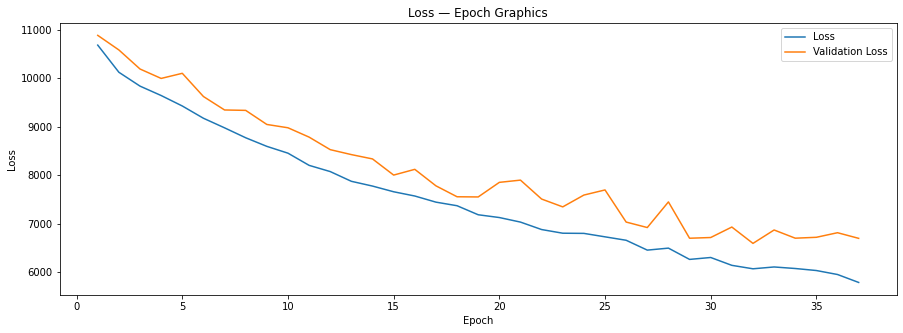

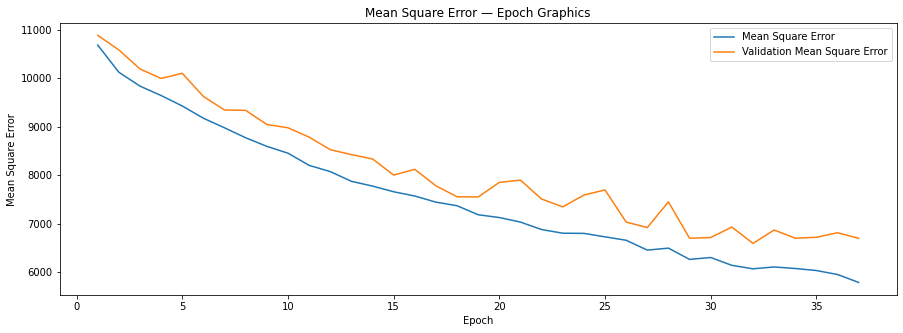

In [24]:
show_results(df1_hist)

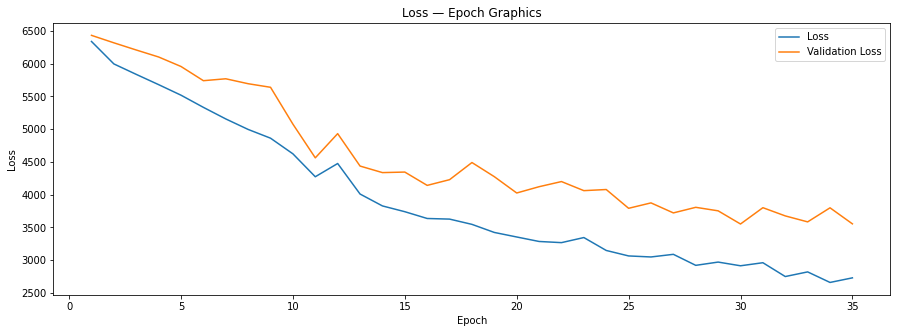

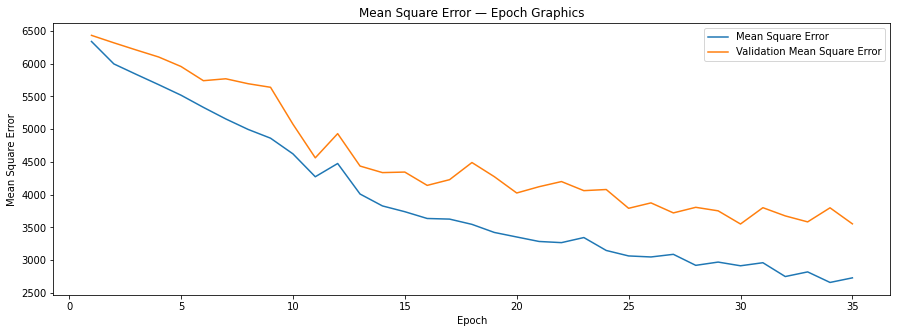

In [25]:
show_results(df2_hist)


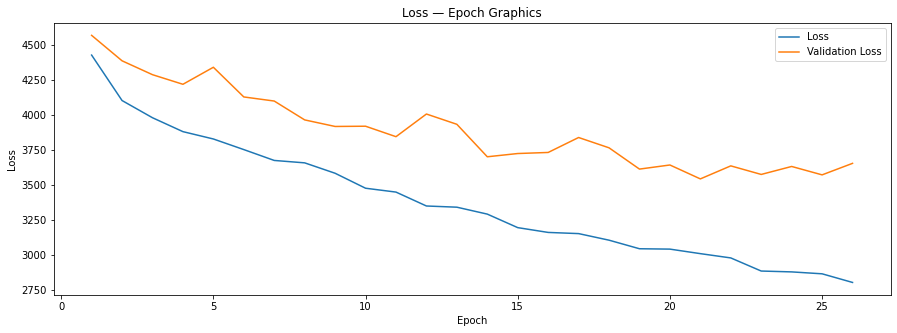

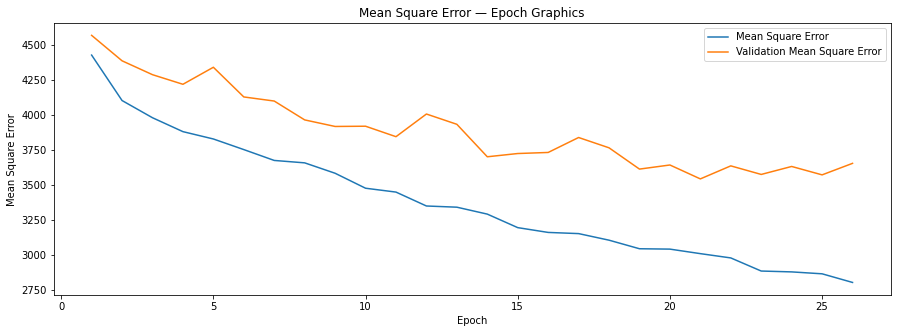

In [26]:
show_results(df3_hist)


In [27]:
from keras import callbacks
earlystopping = callbacks.EarlyStopping(monitor ="val_loss", 
                                        mode ="min", patience = 5, 
                                        restore_best_weights = True)

In [28]:
def get_data(table_name:str)-> pd.DataFrame:
    sql = f"""
                SELECT *
                FROM {table_name}
        """ 
    df = db_reader(sql,'post_procces_data')
    df = utf.get_dummies(['weekday','time_binned'],df)
    return df

In [29]:
def get_test_train_data(df):

    y,X = utf.split_X_y(df,'num_of_taxis')
    X_train_scaler = StandardScaler()
    X_test_scaler = StandardScaler()

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1357)

    X_train_scaled = X_train_scaler.fit_transform(X_train)
    X_test_scaled = X_test_scaler.fit_transform(X_test)
    return X_train_scaled,X_test_scaled,y_train,y_test

In [30]:
# Option One, Rmse about ~68 but will return nan's after some iteration.
def build_model(hp):
  model = keras.Sequential()
  
  # Tune the number of units in the first Dense layer
  # Choose an optimal value between 32-512
  hp_units1 = hp.Int('units1', min_value=32, max_value=512, step=32)
  hp_units2 = hp.Int('units2', min_value=32, max_value=512, step=32)
  hp_units3 = hp.Int('units3', min_value=32, max_value=512, step=32)
  hp_units4 = hp.Int('units4', min_value=32, max_value=512,step=32)
  model.add(layers.Dense(units=hp_units1, activation='relu'))
  model.add(layers.Dense(units=hp_units2, activation='relu'))
  model.add(layers.Dense(units=hp_units3, activation='relu'))
  model.add(layers.Dense(units=hp_units4, activation='relu'))
  model.add(layers.Dense(1, kernel_initializer='normal', activation='linear'))


  model.compile(
      optimizer=keras.optimizers.Adam(),
      loss='mse',
      metrics=['mse']
  )
  return model

In [31]:
def get_best_network(df:pd.DataFrame,df_name:str):
    
    get_test_train_data(df)
    X_train_scaled,X_test_scaled,y_train,y_test = get_test_train_data(df)


    tuner = Hyperband(
    build_model,
    objective='mse',
    max_epochs=10,
    directory='keras_tuner_mse',
    project_name=f'{df_name}'
    )

    tuner.search(X_train_scaled, y_train, epochs=10, validation_split=0.2)
    for h_param in [f"units{i}" for i in range(1,4)]:
        print(h_param, tuner.get_best_hyperparameters()[0].get(h_param))
    return tuner.get_best_models()[0],X_train_scaled,y_train


In [32]:
def train_model(best_model,X_train_scaled,y_train):
    hist = best_model.fit(
    X_train_scaled, 
    y_train,
    epochs=100,
    batch_size=256,
    validation_split=0.2,
    callbacks =[earlystopping]
    )
    return hist
    

In [33]:
def show_results(hist):
    import matplotlib.pyplot as plt
    figure = plt.gcf()
    figure.set_size_inches((15, 5))
    plt.title('Loss — Epoch Graphics')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(range(1, len(hist.history['loss']) + 1), hist.history['loss'])
    plt.plot(range(1, len(hist.history['val_loss']) + 1), hist.history['val_loss'])
    plt.legend(['Loss', 'Validation Loss'])
    plt.show()
    figure = plt.gcf()
    figure.set_size_inches((15, 5))
    plt.title('Mean Square Error — Epoch Graphics')
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error')
    plt.plot(range(1, len(hist.history['mse']) + 1), hist.history['mse'])
    plt.plot(range(1, len(hist.history['val_mse']) + 1), hist.history['val_mse'])
    plt.legend(['Mean Square Error', 'Validation Mean Square Error'])
    plt.show()

In [37]:
model_dict = {
    'Model_1':df1_best_model,
    'Model_2':df2_best_model,
    'Model_3':df3_best_model
}
path = r'../models_data/DL/'

for key,value in model_dict.items():
    saved_model.save(value,os.path.join(path,key))

INFO:tensorflow:Assets written to: ../models_data/DL/Model_1\assets
INFO:tensorflow:Assets written to: ../models_data/DL/Model_2\assets
INFO:tensorflow:Assets written to: ../models_data/DL/Model_3\assets
